# Avoid Early Stopping in A/B Tests

> A while ago, my colleague [YinYin Yu](https://www.linkedin.com/in/yinyin-yu-phd-430951109/) mentioned that early stopping could inflate your false positive rate. This gave me an idea to write a simulation to demonstrate how this could happen, as well as look further into the subject. This notebook is my attempt to document what I've learned.

When running an A/B test (experiment), you should outline your testing process _before_ running the experiment, and _not_ change that process in response to what happens during the test. Changing your testing process during the experiment may result in an inflated False Positive Rate (FPR), which is the probability of finding a significant result (rejecting the null hypothesis) when there no true effect. This will make you more often believe there are real results when there are not!

One example of the above is **early or optional stopping**. Roughly speaking, this is where you:

1. Start the experiment
2. As the results come in, you repeatedly check the _p_-value for significance as the experiment progresses. (Also known as _peeking_)
3. Based on the result of (2), you decide whether to let the experiment continue:
     - a. If the _p_-value is not significant, let the experiment run longer to collect more data.
     - b. If the _p_-value **is significant**, stop the experiment and declare a successful outcome.

The step in 3(b) is what causes an inflation of the false positive rate, corrupting the results of your experiments and making you find statistically significant results (at a higher rate than expected) when there should not be any.

## Quick Refresher: Hypothesis Testing and the Significance Level

An A/B test (e.g. changing a button color) is an example of a _hypothesis test_. In an A/B test, the default assumption (or _null hypothesis_, often designated $H_0$) is that there is no difference between the control and treatment groups being tested. The purpose of a hypothesis test is to conduct an experiment and see whether the null hypothesis (your assumptions) can be rejected or not. (You [can't prove the null hypothesis](https://peterchng.com/blog/2020/05/12/testing-for-no-effect/) with such a test, but that's another story altogether)

**When there is no actual difference between the control and treatment groups, _p_-values will have a [uniform distribution between 0 and 1](https://statproofbook.github.io/P/pval-h0)**. ([Another ref](https://towardsdatascience.com/how-to-test-your-hypothesis-using-p-value-uniformity-test-e3a43fc9d1b6))

What this means in practical terms:

- Even if there is no actual different between control and treatment, you can sometimes get large observed differences between them due to random variation across the population being experimented on.
- These large differences result in a low _p_-value, making it seem like there is an actual difference, when there is none.
- This can make it seem like there is a true effect when in fact there is none. This is called a _false positive_.

How can we control the number of false positives when we run A/B tests?

**This where $\alpha$ (_alpha_), or the significance level, comes in.** The choice of $\alpha$ controls your false positive rate (FPR) when we have a **decision rule** such as:

- **If $p \leq \alpha$**: Declare that a true effect exists; reject the null hypothesis and proclaim statistical significance. (e.g. changing the button color really did help improve click-through rate)
- **If $p > \alpha$**: Declare that there is not enough evidence to reject our initial assumption of no difference.

If we follow this rule correctly, then no more than $\alpha$ fraction of statistically significant results will be false positives. This is because under the null hypothesis (no difference between control and treatment groups), the distribution of _p_-values will be uniform between 0 and 1, as previously said. ($\alpha$ is typically set to $0.05$, but the proper choice of $\alpha$ is a whole other discussion)

If we assume that $\alpha = 0.05$, this means that **when there is actually no difference between control and treatment**, we will have false positives no more than 5% of the time. This is because under a uniform distribution of _p_-values, no more than 5% will be between $[0, 0.05]$.

However, this assumes that the test procedure (in particular, how our decision rule is applied) is followed properly. Let's see what happens when we do not follow the procedure properly.

# Example of how the False Positive Rate is increased by early stopping using a simulation

To see what happens to the number of false positives when we naively do early stopping, let's run a simulation. This simulation will compare the proportion of "successes" between two groups - a control group, and a treatment group. This models any A/B test where the response variable is binary, like a click-through rate. **Specifically for each test we will:**

1. Draw a number of samples $n_1$ for the control group where each sample has a probability of success of $p_1$. Count the successes as $x_1$.
2. Draw an equal number of samples $n_2$ for the treatment group where each sample has a probability of success of $p_2$. Count the successes as $x_2$.
3. Compare the proportion of successes in control ($x_1\over{n_1}$) vs. treatment ($x_2\over{n_2}$) to determine whether the difference is statistically significant.
4. The null hypothesis $H_0$, which is being tested, is that there is no difference between the two groups, i.e. $p_1 = p_2$ or the two groups were sampled from the same population.

In our simulation, $p_1$ will be set equal to $p_2$ so that there is indeed no difference between the two groups, and thus we **know** that our null hypothesis $H_0$(assumption of no difference) is true.

**We will run many of these tests (each test is steps 1-4 above), and then determine how often we had false positives with and without early stopping.**

In [1]:
# Imports
import random
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt

## Aside: _p_-value calculation
The type of hypothesis test we are doing is a two-sample, two-tailed proportions test. We want to compare whether the proportion of successes in one group is statistically different from the proportion of success in another group:
- The null hypothesis is that there is no difference.
- The test can be done with a [normal approximation](https://www.itl.nist.gov/div898/handbook/prc/section3/prc33.htm) if certain conditions hold (such as a "large enough" sample size)
- We will be using such a normal approximation instead of an exact test like [Fisher's test](https://en.wikipedia.org/wiki/Fisher%27s_exact_test), which is difficult to calculate for larger sample sizes.
- A [Chi-squared test](https://en.wikipedia.org/wiki/Chi-squared_test) can be used instead if there are more than two groups or more than two categories of outcomes.
- Note that an **approximate test** like this [_does not_ guarantee](https://en.wikipedia.org/wiki/Exact_test) that our false positive rate will be no more than $\alpha$, our desired Type I error rate. Instead, we only have an approximation that will be more accurate as the sample size increases.

To do the test, we need a way to calculate the _p_-value. The function which does that is defined below, along with my explanation of the process.

In [2]:
# Normal Approximation to a Binomial Distribution for a two-sample, two-tailed proportions test: [1]
# - The p-value from this test answers the question: "If the two samples were drawn from the same population, how likely is it that we would observe the given difference in proportions?"
# - Various references state that this approximate test can be used when n is "sufficiently large or p is close to 1/2."
# - Other guidelines state that it can be used when n*p >= M and n*(p-1) >= M, where M is some number like 5, or 10.
# - Strictly speaking the error from this approximation is: (See [2] below)
#   a. Minimized when p = 1/2. (All else being equal)
#   b. Inversely related to the square root of n.
# - For our purposes, the sample sizes we use are probably large enough so as to make the error from this
#   approximation negligible for the purposes of this simulation.
# References:
# 1. https://www.itl.nist.gov/div898/handbook/prc/section3/prc33.htm
# 2. https://www.johndcook.com/blog/normal_approx_to_binomial/
# 3. https://revisionmaths.com/advanced-level-maths-revision/statistics/normal-approximations

# z-score: from two-sample difference of proportions: this uses a normal approximation.
# 1. Calculate the difference in proportions as if it was a value from a normal distribution with mean 0.
# 2. Then determine how many standard deviations that value is away from 0. This value is the z-score.
def z_score(x_1, n_1, x_2, n_2):
  # Proportion of successes in group 1 sample
  p_hat_1 = x_1/n_1
  # Proportion of successes in group 2 sample
  p_hat_2 = x_2/n_2

  # Pooled proportion of successes
  p_hat = (x_1 + x_2)/(n_1 + n_2)

  # Estimate of the variance of the test statistic: (p_hat_1 - p_hat_2)
  # https://stats.stackexchange.com/questions/361015/proof-of-the-standard-error-of-the-distribution-between-two-normal-distributions/361048
  pooled_variance = p_hat * (1 - p_hat) # Estimate of population variance
  test_statistic_variance = pooled_variance * (1/n_1 + 1/n_2) # By the properties of variance
  test_statistic_standard_error = np.sqrt(test_statistic_variance)

  # The z-score is the difference in proportions normalized/divided by the standard error.
  z = (p_hat_1 - p_hat_2)/test_statistic_standard_error
  return z

# p-value is obtained from the z-score.
def p_value_z_score(x_1, n_1, x_2, n_2):
  z = z_score(x_1, n_1, x_2, n_2)
  # Two-tailed test, i.e. consider differences in either direction.
  # This uses the survival function (complement of CDF) to determine how much area is under the normal curve from the z-score to infinity.
  # It is multiplied by two because we are using a two-tailed test (and the normal distribution is symmetric about 0)
  p_value = scipy.stats.norm.sf(abs(z)) * 2
  return p_value

In [3]:
# Common Definitions
n_1 = 1500         # Sample size of group 1
n_2 = 1500         # Sample size of group 2
p_1 = 0.5          # Probability of success for group 1 samples
p_2 = 0.5          # Probability of success for group 2 samples
alpha = 0.05       # Significance level; reject H_0 if p-value is <= alpha
num_tests = 20000  # Number of tests to run
random.seed(1234)  # To get reproducible results; set to None to disable (NOTE: You need to restart the runtime to get reproducible results)

## Scenario 1: No early/optional stopping:
1. Collect all samples for both groups for the test.
2. Calculate the _p_-value **once** per test.
3. Use that **single** _p_-value to determine whether to reject the null hypothesis, i.e. do we have statistical significance?
4. Count the number of times we (incorrectly) reject the null hypothesis (get a statistically significant result) this way.


In [4]:
# NOTE: This simulation could probably be done more efficiently, but is written in a simple/naive way
# so that it can be more easily compared with the early stopping example later.

num_reject_null = 0 # The number of times we reject the null hypothesis.
p_values = [] # Collect all p-values simulated.
for test_number in range(num_tests):
  x_1 = 0 # Number of successes for group 1
  x_2 = 0 # Number of successes for group 2
  
  # Draw enough samples for group 1 and group 2.
  n = max(n_1, n_2)
  for sample_num in range(n):
    # Any more samples needed for group 1?
    if sample_num < n_1:
      if random.random() < p_1:
        x_1 += 1
    # Any more samples needed for group 2?
    if sample_num < n_2:
      if random.random() < p_2:
        x_2 += 1
  
  p_value = p_value_z_score(x_1=x_1, n_1=n_1, x_2=x_2, n_2=n_2)
  p_values.append(p_value)

  # Decision rule
  if p_value <= alpha:
    num_reject_null += 1

print('Scenario 1: Results with no early/optional stopping')
print(f'We did {num_tests} tests and found statistically significant results {num_reject_null} times')
print(f'This is a false positive rate of {num_reject_null/num_tests} which compares with alpha = {alpha}')

Scenario 1: Results with no early/optional stopping
We did 20000 tests and found statistically significant results 1039 times
This is a false positive rate of 0.05195 which compares with alpha = 0.05


**If we are doing our tests correctly, the fraction of times that we get statistically significant results should be approximately $\alpha$.** (On account of using an approximate test)

This is the purpose of selecting the significance level $\alpha$ - it is trying to control the number of false positives or _Type I_ errors. If we use the process correctly, the _false positive rate_ (the probability of incorrectly rejecting the null hypothesis when it is actually true) should be no more than the $\alpha$ level we have set.

Note that we can only calculate our false positive rate because we _know_ that the null hypothesis is true here - since we defined $p_1 = p_2$. However in most cases you don't know such parameters - that is why you are running the A/B test!

We can also plot a histogram of the _p_-values. It should be _roughly_ uniform between $[0, 1]$.

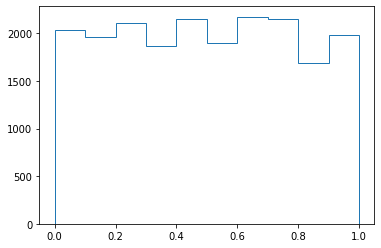

In [5]:
# NOTE: At higher bin counts, the result can look non-uniform. This is because: 
# 1. The underlying process producing the data is binomial, a discrete distribution.
# 2. This causes the range of p-values to be limited to discrete values, making the overall distribution discrete, not continuous.
# 3. This causes p-value to "clump" together.
# 4. At coarse enough bin levels, (e.g. bins=10) it mostly look uniform.
# 5. When the number of bins is increased, you will begin to see gaps between the bins, reflecting that some p-values are impossible to obtain under this particular discrete distribution.
# For more info, see: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6629378/
# - Section: "The distribution of p values under H 0"
# - Relevant excerpt: "The p value of Fisher’s exact test is different. Its range is discrete. When the sample size is small, its distribution may be far away from the uniform distribution.
#   However, when the sample size is large enough, the p value of the Fisher’s exact is the same as Pearson’s χ2 test. Of course, it is not a wise way to calculate the exact p value in that case."
counts, bins = np.histogram(p_values, bins=10)
plt.stairs(counts, bins)

## Scenario 2: Early/Optional Stopping: Stop after every $k$ samples and naively check for significance
1. We collect up to $n_1$ and $n_2$ samples, and every $k$ samples ($k < n_1, k < n_2$) we stop to calculate the "current" _p_-value.
2. This means the _p_-value is being calculated **up to** $\lceil{n\over{k}}\rceil$ times for each test where $n = \max\{n_1, n_2\}$
3. Each time we calculate a _p_-value, check whether to reject the null hypothesis, e.g. is the _p_-value significant? **If it is significant, then we stop the experiment early and declare a significant result.**
4. Count the number of times we (incorrectly) reject the null hypothesis (get a statistically significant result) this way.

In [6]:
k = 100 # Every k samples we will calculate a p-value and check for significance.
num_reject_null_2 = 0 # The number of times we reject the null hypothesis.
p_values_2 = [] # Collect all p-values simulated.
for test_number in range(num_tests):
  x_1 = 0 # Number of successes for group 1
  x_2 = 0 # Number of successes for group 2
  
  # Draw enough samples for group 1 and group 2.
  n = max(n_1, n_2)
  for sample_num in range(n):
    # Any more samples needed for group 1?
    if sample_num < n_1:
      if random.random() < p_1:
        x_1 += 1
    # Any more samples needed for group 2?
    if sample_num < n_2:
      if random.random() < p_2:
        x_2 += 1
  
    # Every k samples (or at the end) calculate the p-value.
    if sample_num > 0 and (sample_num % k == 0 or sample_num == n - 1):
      p_value = p_value_z_score(x_1=x_1, n_1=n_1, x_2=x_2, n_2=n_2)
      
      # Decision: Does p-value <= alpha? Stop early if so.
      if p_value <= alpha:
        num_reject_null_2 += 1
        break

  p_values_2.append(p_value)

print('Scenario 2: Results with no early/optional stopping')
print(f'We did {num_tests} tests and found statistically significant results {num_reject_null_2} times')
print(f'This is a false positive rate of {num_reject_null_2/num_tests} which compares with alpha = {alpha}')

Scenario 2: Results with no early/optional stopping
We did 20000 tests and found statistically significant results 1981 times
This is a false positive rate of 0.09905 which compares with alpha = 0.05


**With early/optional stopping the observed false positive rate can be much higher than $\alpha$**. This means we will think we have statistically significant results much more often than we actually do!

This is because we are not using $\alpha$ properly and can no longer properly control for Type I (false positive) errors.

Checking for statistical significance multiple times during the course of the test as you accumulate observation is essentially a form of [multiple comparisons](https://en.wikipedia.org/wiki/Multiple_comparisons_problem). You need to account for this in your testing procedure and not use $\alpha$ _as if_ you had only computed the _p_-value once at the end of the experiment.

The histogram of _p_-values seems to confirm this: We appear to have more lower _p_-values than would be expected from a uniform distribution.

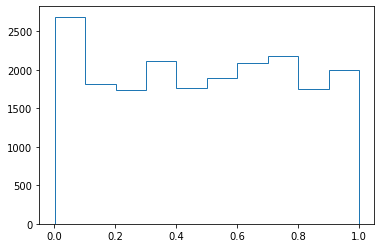

In [7]:
counts_2, bins_2 = np.histogram(p_values_2, bins=10)
plt.stairs(counts_2, bins_2)

## Some lessons from this exercise

- The _p_-value **itself** can be seen as a random variable that is uniformly distributed under the null hypothesis.
- If you calculate the _p_-value as results come in (looking early, or peeking), it is _somewhat_ like sampling that random variable.
- An increased number of looks thus gives you more "chances" of getting a statistically significant _p_-value, thus inflating your rate of false positives or Type I errors.

The _p_-value will tend to vary the most early on when the number of samples is low. After you have obtained a large amount of samples (assuming the underlying population being sampled is not changing over time), the _p_-value will [tend to "stabilize/converge" to the "true" _p_-value](https://towardsdatascience.com/how-not-to-run-an-a-b-test-88637a6b921b).

However, with a _very_ large number of samples, you may find effect size differences that are too small to be practical. 

So how do you decide **upfront** when to end your experiment? Ideally you would do a **power analysis** before you start the experiment:

1. Decide what is the smallest effect size that would be practically significant, e.g. a 0.1% increase in CTR.
2. Decide what statistical power you want, i.e. given an effect size of 0.1%, I want an 80% chance of getting a stat. sig result.
3. Decide what your acceptable Type I error rate, i.e. your $\alpha$ value should be. It might be 5%, or it might be something else, depending on the cost trade-offs between false positives and false negatives.
4. From the above three, calculate the minimum number of samples needed to fulfill those criteria using a sample size power calculator.

(This is just a high-level summary and the a detailed treatment of power analysis is beyond the scope of this article)

Whatever you do, it's important to not modify your test procedure in an ad-hoc manner once the test has started, i.e. decide to collect more samples just because the results "don't look good", as such behaviors can inflate error rates.

# Valid reasons for early stopping

In our example simulation above, we decided to peek at results and stop early **only if** the _p_-value was significant. This is not a valid reason, because it biases the outcome toward a significant result, which inflates the false positive rate as we saw. Essentially, we are "looking" for a certain result which causes the bias.

There are, however, valid reasons to stop a hypothesis test earlier than you initially planned due to unexpected early results. These are usually when you see an unexpectedly large effect size that has practical significance. Some examples:

1. **An A/B test is resulting in significant negative metric impact**: If early in your experiment, you see significant negative results (both in a practical and statistical sense), it's probably wise to terminate the experiment early. Something is probably wrong, and terminating the experiment early so you can investigate the cause is prudent.
2. **Withholding the potential treatment benefits from the control group would be unethical**: This usually doesn't apply to typical A/B tests, but instead mainly to randomized controlled trials (RCTs) that are assessing the efficacy of some medical or pharmaceutical treatment. These RCTs are also a form of hypothesis test. If testing the efficacy of a potential life-saving treatment, you may find out relatively early on that the benefit is so large and unexpected that it may be considered unethical to continue to withhold that treatment from the control group. (Usually there are [guidelines](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3844122/) around this)



# How to control for early stopping

**When the cost of obtaining samples is high, we may want to stop early if certain criteria are met.** Early stopping in and of itself is not necessarily bad. Instead, it's the lack of a proper test design that is the problem. We already saw that using a simple stopping rule like "_terminate if *p*-value is less than $\alpha$, and continue if not_" leads to an inflated false positive rate. Can we use early stopping _and_ also control our false positive rate so it is limited by $\alpha$?

There are some techniques, and this is is the subject of 2021 paper by Lakens et al. entitled [_Group Sequential Designs: A Tutorial_](https://psyarxiv.com/x4azm). The basic idea behind such _Group Sequential Designs_ is that if we are looking at the data multiple times as the results come in, we need to adjust the _p_-value threshold **down** from the original $\alpha$ level in order to keep the false positive rate under control. The steps are roughly:

1. Decide what you want your overall false positive rate (Type I errors) to be bounded by. This is your $\alpha$ value as before.
2. This value of $\alpha$ can be considered your "budget".
3. As before, do a power analysis to determine your maximum sample size.
4. Decide how you want to spend your "budget" each time you want to look early at the results and potentially stop the experiment. 
5. This requires specifying an _alpha-spending_ function. This function will determine a _p_-value threshold that is _lower_ than your overall $\alpha$ level. This _p_-value threshold must be used to make a decision on statistical significance each time you look early at interim results.

The simplest of these approaches is the [Pocock correction](https://en.wikipedia.org/wiki/Pocock_boundary). Because it is simple, it imposes some restrictions:
1. The number of interim looks (stops) must be specified in advance.
2. The number of samples collected in between looks must be equal.

For example, if we have an overall $\alpha$ of $0.05$ and we plan to stop five times to look at the results, we have to use an adjusted _p_-value threshold of $0.0158$. This means we can only consider a result statistically significant (and potentially stop early) if $p < 0.0158$. Doing this up to five times will ensure we stay within our overall Type I error rate $\alpha = 0.05$. (This is conceptually similar to the [Bonferroni correction](https://en.wikipedia.org/wiki/Bonferroni_correction) for multiple comparisons)

For the Pocock correction, the alpha-spending function essentially "divides" the original $\alpha$ value equally. There are more complex alpha-spending functions that _do not_ require you to specify the number nor timing of the interim looks ahead of time. (The section _Stopping for Futility_" outlines an approach to control Type II errors across multiple looks as well)

However, you still need to take care to not make decisions about when to do the interim looks based on the results, since that will introduce bias into the experiment. For example, deciding to do an interim look when the _p_-value "looks good" is a recipe for bias.

These methods introduce a methodical way to do early stopping, _taking into account_ the impact of the interim looks and using it to adjust the _p_-value threshold accordingly to avoid inflating your false positive rate. The trade-off is a more complex test design. **Hence, such test designs are usually used when the cost of getting more samples is high, and you want to be able to make a decision on early data and have the option to end the test early to save on resources.** This is summarized in a quote from Lakens' paper:

> "Resources in science are limited, and given that group sequential designs can save both time and money required to compensate participants, it is surprising that group sequential designs are not used more widely."

If the cost of getting more samples is low, it's probably not worthwhile to take on a more complex test design.

# References
1. [How Not to Run an A/B Test](https://towardsdatascience.com/how-not-to-run-an-a-b-test-88637a6b921b)
2. [Early stopping in A/B testing](https://bytepawn.com/early-stopping-in-ab-testing.html)
3. [Group Sequential Designs: A Tutorial](https://psyarxiv.com/x4azm)
4. [How to do A/B test with early stopping correctly](https://www.aarondefazio.com/tangentially/?p=83)
5. [When to Adjust Alpha During Multiple Testing: A Consideration of Disjunction, Conjunction, and Individual Testing](https://arxiv.org/ftp/arxiv/papers/2107/2107.02947.pdf)
6. [A better stopping rule for conventional statistical tests](https://link.springer.com/content/pdf/10.3758/BF03209488.pdf)
7. [Example 111.3 Testing an Effect with Early Stopping to Accept $H_0$](https://documentation.sas.com/doc/en/pgmsascdc/v_023/statug/statug_seqtest_examples03.htm)

